In [3]:

import pandas as pd
import os

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool


def genDataFrame(f_dataFile):


    base_path = "/sharedMasterRSI/datasets/robocupDataset/"

    l_header = os.path.splitext(os.path.basename(f_dataFile))[0]

    # Read text file into DataFrame
    df = pd.read_csv(f_dataFile, sep="\s+", header=None, names=["path", "label"])

    #print(df.iloc[0,0])
    #print(df.head(4))

    # Convert label to integer
    df["label"] = df["label"].astype(int)


    #Replace part of imagePath with base_path
    df["path"] = df["path"].str.replace("/PATH/TO/DATABASE/DIRECTORY/athome/", base_path)

    # Calculate label distribution
    label_dist = df["label"].value_counts() 

    #print()
    #print(label_dist.head(10))


    # create a ColumnDataSource with the data
    source = ColumnDataSource(data=dict(x=label_dist.index, y=label_dist))

    # create a stem plot
    p = figure(width=1000, height=400,tools='hover', tooltips=[("y", "@y")])
    p.segment(label_dist.index, [0]*len(label_dist.index), label_dist.index, label_dist, line_width=2)
    p.circle(label_dist.index, label_dist, size=10, fill_color="white")

    # add hover tool
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [('y', '@y')]

    # show the plot
    show(p)

    return df



trainDf = genDataFrame("/sharedMasterRSI/datasets/robocupDataset/training_split.txt")
validationDf = genDataFrame("/sharedMasterRSI/datasets/robocupDataset/validation_split.txt")

l_numDataTrain = len(trainDf)
l_numDataValidation = len(validationDf)

print("\nNum data for train ", l_numDataTrain)
print("\nNum data for validation ", l_numDataValidation)

print("Expected size in memory to store all images assumming each image is 16kB : ", 16*(l_numDataTrain + l_numDataValidation)/1024/1024 , " aprox Gb")

#Obtain mean size of images


#Obtain list with different image extensions







Num data for train  156883

Num data for validation  39312
Expected size in memory to store all images assumming each image is 16kB :  2.9936981201171875  aprox Gb


In [47]:
#Create tensorflowd dataset from pandas data frame
import tensorflow as tf

trainDs = tf.data.Dataset.from_tensor_slices((trainDf['path'].values, trainDf['label'].values))
validationDs = tf.data.Dataset.from_tensor_slices((validationDf['path'].values, validationDf['label'].values))

print("trainDs info ", trainDs.element_spec)

# Define preprocessing layers
# preprocessing_layers = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    
# ])
l_numLabels = 180
l_batchSize = 32


def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Preprocess dataset on GPU
trainDs = trainDs.map(lambda x, y: (preprocess_image(x,y)), num_parallel_calls=tf.data.AUTOTUNE).batch(l_batchSize).prefetch(tf.data.AUTOTUNE)

print("trainDs info after processing ", trainDs.element_spec)

# Create model
l_baseModel = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
l_baseModel.trainable = False
model = tf.keras.models.Sequential([
    l_baseModel,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(l_numLabels, activation="softmax")
])

model.summary()

# # Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

trainDs info  (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
trainDs info after processing  (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 128)               163968    
                                                                 
 dense_45 (Dense)            (None, 128)         

In [48]:
# Train model

l_numEpochs = 10
history = model.fit(trainDs, epochs=l_numEpochs)


Epoch 1/10
 799/4903 [===>..........................] - ETA: 1:49 - loss: 4.8423 - sparse_categorical_accuracy: 0.1056

KeyboardInterrupt: 

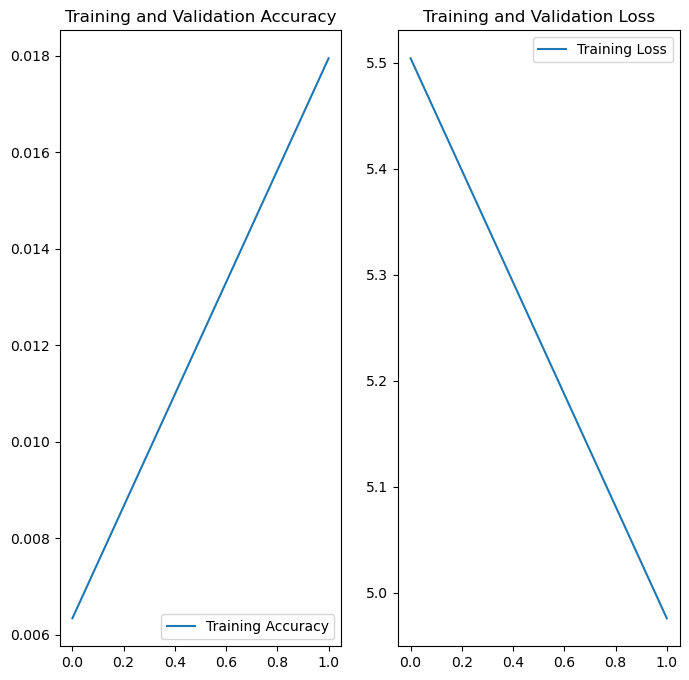

In [34]:
#Evaluate results of trained models
import matplotlib.pyplot as plt


acc = history.history['sparse_categorical_accuracy']
#val_acc = history.history['loss']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



